The goal is to build a model to predict physician specialty type from symptoms. I use the dataset that I created in Uumls_analysis.

let's start with importing some packages.

In [1]:
import pandas as pd
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

The first step is to read the dataset and preview using `head()` function.

In [6]:
path = < path to discipline_symptoms_umls2.csv>
data = pd.read_csv(path,sep='delimiter', header=None)
data = data[0].str.split(",", expand=True)
data.columns = ['specialist','disease','symptom']
data.head()

,specialist,disease,symptom
0,C0007189,C0003850,C0002962
1,C0007189,C0002963,C0348588
2,C0007189,C0042420,C0042571
3,C0007189,C0042420,C1710621
4,C0007189,C0235522,C0235524


Let's count how many different disease or symptoms are available for each specialist. For example, Neurology speciality has the most dieases and symptoms.

In [20]:
data['specialist'].value_counts()

C0027855    174
C0017163     91
C0021782     68
C0007189     57
C0080339     23
C0042077     22
C0011627     20
C0014137     17
C0029087     13
C0018417     12
C0035452      9
C0029335      7
C0027712      6
C0031098      4
C0029450      4
C0032331      1
C0031330      1
Name: specialist, dtype: int64

Here, I find the most frequent symptoms and their counts.

In [21]:
symptoms = np.concatenate([data['symptom'].values])
symptoms =symptoms[symptoms!=None]
symptoms_dict = np.unique(symptoms, return_counts=True)
idx = np.argsort(-symptoms_dict[1])
symptoms_pd = pd.DataFrame()
symptoms_pd['symptom'] = symptoms_dict[0][idx]  
symptoms_pd['count'] = symptoms_dict[1][idx]  
symptoms_pd.head()


,symptom,count
0,C0036572,36
1,C0002962,18
2,C0015230,13
3,C0011991,11
4,C0004134,8


We have 266 unique symptoms.

In [22]:
a = np.unique(data['symptom'].values)
a.shape

(254,)

Now I convert the catogorical variable for symptoms to numerical to prepare it for the model. Note that for each disease and specialist each row contains one symptom. This means that after converting symptom column to dummies each row of the data will have exactly one column with value 1. We aggregate all such rows with identical specialty and disease with the `group_by()` command.

In [71]:
df = data['symptom'].str.get_dummies(sep=',')
df["specialist"] = data["specialist"]
df["disease"] = data["disease"]
df_group = df.groupby(["disease"]).sum()
df_group = pd.merge(df_group,df[["disease","specialist"]].drop_duplicates(),on='disease')
df_group.drop(["disease"],axis=1,inplace=True)
df=df_group
df_group.head()


,C0000729,C0000737,C0001684,C0002962,C0003564,C0003578,C0003862,C0004134,C0004604,C0005858,...,C2364135,C2607896,C2828177,C2921133,C3665346,C3714552,C4048158,C4317123,C4551694,specialist
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,C0014137
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C0014137
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C0029087
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C0027855
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C0021782


Finally, we have a mapping from specialty to symptoms which is ready to be fed into any predictive model. Let's save the table

In [30]:
column_name = list(df.columns.values.tolist()) 
f = open("specialty_symptom_dummy.txt",'w')
for x in column_name:
    f.write(x+"\n")
f.close()

I drop the specialist column and use all dataset for training the model.

In [72]:
train = df.drop(["specialist"], axis=1)
Ytrain = df["specialist"]
logisticRegr = LogisticRegression(fit_intercept = False, C = 1e9)
logisticRegr.fit(train, Ytrain)

LogisticRegression(C=1000000000.0, fit_intercept=False)

We test the model on training data set and check the accuracy.

In [76]:
df_percent = df.sample(frac=0.3)
test = df_percent.drop(["specialist"], axis=1)
Ytest=df_percent["specialist"]
predictions = logisticRegr.predict(test)
score = logisticRegr.score(test, Ytest)
print(score)
test.head()

0.8243243243243243


,C0000729,C0000737,C0001684,C0002962,C0003564,C0003578,C0003862,C0004134,C0004604,C0005858,...,C2364111,C2364135,C2607896,C2828177,C2921133,C3665346,C3714552,C4048158,C4317123,C4551694
230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
70,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
import pickle
pickle.dump(logisticRegr, open(< path to specialist_classifier_logReg_UMLS>, 'wb'))

Here, we split the dataset to training and testing dataset and fitting the model. Then we calculate the score for the testing set.

In [100]:
train, test = train_test_split(df, train_size=0.75, random_state=1987)
traindf = pd.DataFrame(train, columns=df.columns)
testdf = pd.DataFrame(test, columns=df.columns)

Ytrain = traindf['specialist']
Ytest = testdf['specialist']


traindf.drop(['specialist'],axis=1,inplace=True)
testdf.drop(['specialist'],axis=1,inplace=True)

logisticRegr = LogisticRegression(fit_intercept = False, C = 1e9)
logisticRegr.fit(traindf, Ytrain)
predictions = logisticRegr.predict(testdf)
score = logisticRegr.score(testdf, Ytest)
print(score)

0.5161290322580645


I plot the confusion matrix using heat map.

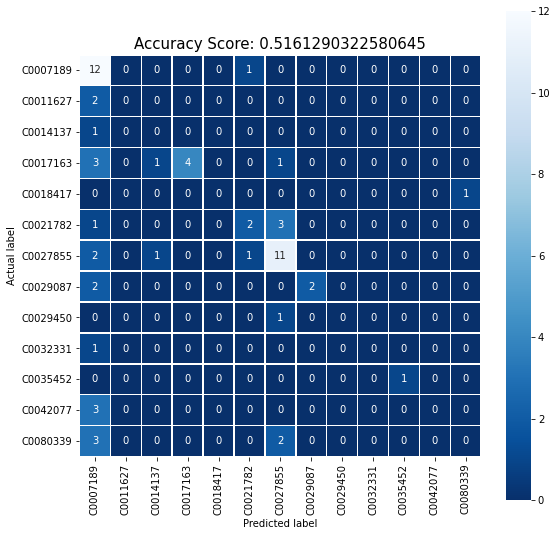

In [103]:
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
idx = sorted(Ytest.unique())
labels=idx
cm = metrics.confusion_matrix(Ytest, predictions,idx)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r',xticklabels=labels, yticklabels=labels);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'F1 Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [196]:
testdf


,AUTOSOMAL RECESSIVE (disorder) Abnormal pyramidal sign,AUTOSOMAL RECESSIVE (disorder) Abnormality of extrapyramidal motor function,AUTOSOMAL RECESSIVE (disorder) Bradykinesia,AUTOSOMAL RECESSIVE (disorder) Muscle Rigidity,AUTOSOMAL RECESSIVE (disorder) Tremor,Adult Form Difficulty passing urine,Adult Form Upper motor neuron signs,Atrophic Dyspepsia,Benign Migratory Glossalgia,Complex Partial Seizures,...,polyalgia,posthemiplegic chorea,primary enuresis,right upper quadrant pain,swelling of eye,tired and heavy,trichorrhexis invaginata,upper abdominal pain,uti symptoms,vein pain
473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
379,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
